In [1]:
# import sys 
# sys.path.append('~/DL_project/MyProblem/') 
from DTLZ1 import DTLZ1
import geatpy as ea

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable
import time
import matplotlib.pyplot as plt 
import numpy as np 
import math

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = 'cpu'
seed = 1
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [2]:
class Net(nn.Module):
    def __init__(self, N):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(N, 5000)
        self.fc2 = nn.Linear(5000, 1)
#         self.fc4 = nn.Linear(200, 3)
        # self._initialize_weights()

    def forward(self, x):
        x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = F.relu(self.fc3(x))
        x = self.fc2(x)
        return x


In [3]:
def train(model, data_1, target_1, test_data, test_target, test_pop, N, test_N, epochs, optimizer, criterion):
    model.train()
    train_accuracy_1 = []
    train_accuracy_2 = []
    train_good = []
    train_bad = []
    test_accuracy = []
    test_accuracy_good = []
    test_accuracy_bad = []
    train_loss_1 = []
    train_loss_2 = []
    test_loss = []
    train_time = []
#     predicts_data = []
    n = 20

    for epoch in range(1, epochs+1):
        run_time = time.time()
        optimizer.zero_grad()
        output_1 = model(data_1)
        target_bad = target_1[np.where(target_1==0)[0]]
        output_bad = output_1[np.where(target_1==0)[0]]
#         loss_1 = criterion(output_1, target_1)
        loss_1 = criterion(output_bad, target_bad)
        loss_1.backward()
        optimizer.step()
        
        optimizer.zero_grad()
        output_2 = model(data_1)
        target_good = target_1[np.where(target_1==1)[0]]
        output_good = output_2[np.where(target_1==1)[0]]
        loss_2 = criterion(output_good, target_good)
        loss_2.backward()
        optimizer.step()
        
        output_2[np.where(output_2<0.5)[0]] = 0
        output_2[np.where(output_2>=0.5)[0]] = 1
        accuracy_train_1 = (1 - sum(torch.abs(output_1-target_1)).detach().numpy()/N) * 100
        accuracy_train_2 = (1 - sum(torch.abs(output_2-target_1)).detach().numpy()/N) * 100
        accuracy_good = (1 - sum(torch.abs(output_good-target_good)).detach().numpy()/N) * 100 
        accuracy_bad = (1 - sum(torch.abs(output_bad-target_bad)).detach().numpy()/N) * 100 
        
        run_time = time.time() - run_time
        train_loss_1.append(loss_1.item())
        train_loss_2.append(loss_2.item())
        train_accuracy_1.append(accuracy_train_1)
        train_accuracy_2.append(accuracy_train_2)
        train_good.append(accuracy_good)
        train_bad.append(accuracy_bad)
        train_time.append(run_time)
        
        output_test = model(test_data)
        loss_test = criterion(output_test, test_target)
        output_test[np.where(output_test<0.5)[0]] = 0
        output_test[np.where(output_test>=0.5)[0]] = 1
        test_target_good = test_target[np.where(test_target==1)[0]]
        test_output_good = output_test[np.where(test_target==1)[0]]
        test_target_bad = test_target[np.where(test_target==0)[0]]
        test_output_bad = output_test[np.where(test_target==0)[0]]
        accuracy_test = (1 - sum(torch.abs(output_test-test_target)).detach().numpy()/test_N) * 100 
        accuracy_test_good = (1 - sum(torch.abs(test_output_good-test_target_good)).detach().numpy()/test_N) * 100 
        accuracy_test_bad = (1 - sum(torch.abs(test_output_bad-test_target_bad)).detach().numpy()/test_N) * 100 
        test_loss.append(loss_test.item())
        test_accuracy.append(accuracy_test)
        test_accuracy_good.append(accuracy_test_good)
        test_accuracy_bad.append(accuracy_test_bad)
        if epoch % n == 0:
            print('epoch:', epoch)
            print('Train accuracy 1 = {:.2f}%, Train accuracy 2 = {:.2f}%,, Train good = {:.2f}%, Train bad = {:.2f}%'.format(np.mean(train_accuracy_1[epoch-n:epoch-1]), np.mean(train_accuracy_2[epoch-n:epoch-1]), np.mean(train_good[epoch-n:epoch-1]), np.mean(train_bad[epoch-n:epoch-1])))
            print('Test accuracy = {:.2f}%, Test good = {:.2f}%, Test bad = {:.2f}%'.format(np.mean(test_accuracy[epoch-n:epoch-1]), np.mean(test_accuracy_good[epoch-n:epoch-1]), np.mean(test_accuracy_bad[epoch-n:epoch-1])))
            print('Train loss = {:.4f}, Test loss = {:.4f}, Total time = {:.4f}'.format(np.mean(train_loss_1[epoch-n:epoch-1]), np.mean(test_loss[epoch-n:epoch-1]), sum(train_time[epoch-n:epoch-1])))
            fig = plt.figure()
            ax = fig.add_subplot(projection='3d')
            ax.scatter(test_pop.ObjV[np.where(output_test==1)[0], [0]], test_pop.ObjV[np.where(output_test==1)[0], [1]], test_pop.ObjV[np.where(output_test==1)[0], [2]])
            ax.scatter(test_pop.ObjV[np.where(output_test==0)[0], [0]], test_pop.ObjV[np.where(output_test==0)[0], [1]], test_pop.ObjV[np.where(output_test==0)[0], [2]], alpha=0.1)
            plt.show()
            
#             print('Train loss 1 = {:.4f}, Train loss 2 = {:.4f}, Test loss = {:.4f}, Total time = {:.4f}'.format(np.mean(train_loss_1[epoch-n:epoch-1]), np.mean(train_loss_2[epoch-n:epoch-1]), np.mean(test_loss[epoch-n:epoch-1]), sum(train_time[epoch-n:epoch-1])))
#             print('target1-output1 = ', target_1-output_1)
#             print('target2-output2 = ', target_2-output_2)
#     predicts_data.append(output.cpu().detach().numpy())
#     predicts_data = np.hstack(predicts_data)
                  
    fig = plt.figure()
    t = list(range(epochs))
    plt.plot(t, train_loss_2)
    plt.xlabel('Epoch Number')
    plt.ylabel('Train Loss 2')
    plt.show()
    
    fig = plt.figure()
    t = list(range(epochs))
    plt.plot(t, train_accuracy_2)
    plt.xlabel('Epoch Number')
    plt.ylabel('Train Accuracy 2')
    plt.show()
    
    fig = plt.figure()
    t = list(range(epochs))
    plt.plot(t, train_good)
    plt.xlabel('Epoch Number')
    plt.ylabel('Train good')
    plt.show()
    
    fig = plt.figure()
    t = list(range(epochs))
    plt.plot(t, train_bad)
    plt.xlabel('Epoch Number')
    plt.ylabel('Train bad')
    plt.show()
    
    fig = plt.figure()
    t = list(range(epochs))
    plt.plot(t, test_accuracy_good)
    plt.xlabel('Epoch Number')
    plt.ylabel('Test good')
    plt.show()
    
    fig = plt.figure()
    t = list(range(epochs))
    plt.plot(t, test_accuracy_bad)
    plt.xlabel('Epoch Number')
    plt.ylabel('Test bad')
    plt.show()
    
#     fig = plt.figure()
#     t = list(range(epochs))
#     plt.plot(t, test_loss)
#     plt.xlabel('Epoch Number')
#     plt.ylabel('Test Loss Value')
#     plt.show()
    
#     fig = plt.figure()
#     t = list(range(epochs))
#     plt.plot(t, train_time)
#     plt.xlabel('Epoch Number')
#     plt.ylabel('Train Time')
#     plt.show()

#     return train_loss_1, train_loss_2, train_time, test_loss #, predicts_data

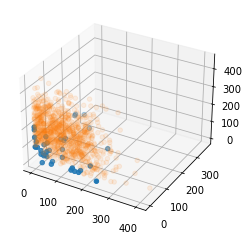

Net(
  (fc1): Linear(in_features=7, out_features=5000, bias=True)
  (fc2): Linear(in_features=5000, out_features=1, bias=True)
)
epoch: 20
Train accuracy 1 = 45.77%, Train accuracy 2 = 53.36%,, Train good = 99.95%, Train bad = 45.82%
Test accuracy = 48.15%, Test good = 98.27%, Test bad = 49.88%
Train loss = 0.4409, Test loss = 0.4499, Total time = 206.5650


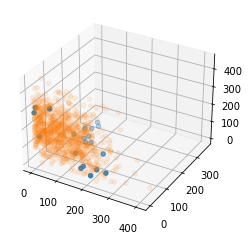

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

Traceback (most recent call last):
  File "D:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-4-3bd8918bec02>", line 64, in <module>
    train(model, data_1, target_1, test_data, test_target, test_pop, N, test_N, epochs, optimizer_2, criterion)
  File "<ipython-input-3-9765b089f94a>", line 39, in train
    accuracy_train_2 = (1 - sum(torch.abs(output_2-target_1)).detach().numpy()/N) * 100
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2061, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'KeyboardInterrupt' object has no attribute '_render_traceback_'

During handling of 

TypeError: object of type 'NoneType' has no len()

In [4]:
myProblem = DTLZ1(M=3)  # 实例化问题对象
N = 100000 # 定义样本数

## 以下部分固定不变，是固定写法（该模块用于生成样本）
Encoding = 'RI'
Field = ea.crtfld(Encoding, list(myProblem.varTypes), myProblem.ranges, myProblem.borders)
pop_1 = ea.Population(Encoding, Field, N)
Vars_1 = ea.crtpc(Encoding, pop_1.sizes, pop_1.Field)  

pop_1.Phen = Vars_1
myProblem.aimFunc(pop_1) 

data_1 = torch.as_tensor((pop_1.Phen-Field[0,:])/(Field[1,:]-Field[0,:]), dtype=torch.float32).to(device)
levels, criLevel = ea.ndsortESS(pop_1.ObjV)
target_1 = np.zeros((N, 1))
target_1[np.where(levels==1)[0]] = 1
target_1 = torch.as_tensor(target_1, dtype=torch.float32).to(device)
# target_1 = torch.as_tensor(pop_1.ObjV, dtype=torch.float32).to(device)
data_1_normal = F.normalize(data_1, p=2, dim=1)
data_num = data_1.shape[0]
Dim = data_1.shape[1]
# target_1_1 = target_1[:,[0]]

# pop_2 = ea.Population(Encoding, Field, N)
# Vars_2 = ea.crtpc(Encoding, pop_2.sizes, pop_2.Field)  
# pop_2.Phen = Vars_2
# myProblem.aimFunc(pop_2) 
# data_2 = torch.as_tensor((pop_2.Phen-Field[0,:])/(Field[1,:]-Field[0,:]), dtype=torch.float32).to(device)
# target_2 = torch.as_tensor(pop_2.ObjV, dtype=torch.float32).to(device)
# data_2_normal = F.normalize(data_2, p=2, dim=1)
# target_2_1 = target_2[:,[0]]


test_N = 1000
test_pop = ea.Population(Encoding, Field, test_N)
test_Vars = ea.crtpc(Encoding, test_pop.sizes, test_pop.Field)
test_pop.Phen = test_Vars
myProblem.aimFunc(test_pop)

test_data = torch.as_tensor((test_pop.Phen-Field[0,:])/(Field[1,:]-Field[0,:]), dtype=torch.float32).to(device)
levels, criLevel = ea.ndsortESS(test_pop.ObjV)
test_target = np.zeros((test_N, 1))
test_target[np.where(levels==1)[0]] = 1
test_target = torch.as_tensor(test_target, dtype=torch.float32).to(device)
# test_target = torch.as_tensor(test_pop.ObjV, dtype=torch.float32).to(device)
test_data_normal = F.normalize(test_data, p=2, dim=1)
# test_target_normal = F.normalize(test_target, p=2, dim=1)
# test_target_1 = test_target[:,[0]]

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(test_pop.ObjV[np.where(test_target==1)[0], [0]], test_pop.ObjV[np.where(test_target==1)[0], [1]], test_pop.ObjV[np.where(test_target==1)[0], [2]])
ax.scatter(test_pop.ObjV[np.where(test_target==0)[0], [0]], test_pop.ObjV[np.where(test_target==0)[0], [1]], test_pop.ObjV[np.where(test_target==0)[0], [2]], alpha=0.1)
plt.show()

epochs = 500
model = Net(N=Dim).to(device)
print(model)
criterion = nn.MSELoss() 
# criterion = nn.BCELoss() 
# criterion = nn.LogSoftmax()
optimizer_1 = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.005)
optimizer_2 = optim.Adam(model.parameters(), lr=0.001)
train(model, data_1, target_1, test_data, test_target, test_pop, N, test_N, epochs, optimizer_2, criterion)


In [ ]:
print(Field[1][0])

In [ ]:
a = torch.as_tensor([1,0,1])
b = torch.as_tensor([2,0,0])
sum(torch.abs(a-b)).detach().numpy()

a[np.where(a>0)[0]]